In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


import tensorflow as tf
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"  #disables GPU 
import matplotlib.pyplot as plt
import numpy as np
#tf.__version__
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

plt.rcParams['figure.figsize'] = [10,10]

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [2]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image

import os
import cv2
import numpy as np
#https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/

def load_img(img_path,gray = False):
    
    if gray:
        return cv2.imread(img_path , cv2.IMREAD_GRAYSCALE) 
    
    im = cv2.imread(img_path ) 
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im

In [3]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

model = VGG16(weights='imagenet',
                  include_top=True,
                  input_shape=(224, 224, 3))

In [50]:
# A function that does the above step but for any all layers in a block
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
def cnn_lap(image, layer_name):
    mag = []
    layer = [l for l in model.layers if layer_name == l.name][0]

    filters = layer.get_weights()

    filtered_img = []
    for i in range(0, 64):
        #plt.imshow(layer_out[0][:,:,2])
        print(i)
        f = filters[0][:, :, i]
        print(f)
        filtered_img.append(cv2.filter2D(image, cv2.CV_32F, kernel=f))

    laps = []
    for i in range(0, 64):
        out = filtered_img[i]
        dst = cv2.Laplacian(out, cv2.CV_32F )
        laps.append(dst)

    mag.append(np.linalg.norm(np.abs(laps), axis = 0))
    #mag.append(np.sum(laps, axis = 0))
    #scaled_mag = min_max_scaler.fit_transform(mag[0])

    #mag /= mag.max()/255.0'''
    return mag[0] * 1.0/mag[0].max()  , filtered_img, np.array(laps)
    #return dst

In [5]:
def local_arg_exrtrema_2(mat1, mat2):

    #Use a moving window to find local max/min in section. Determine coordinate of max pixel in image.
    idx = []
    thresh = np.abs(np.amax(mat2) - np.abs(np.amin(mat2)))
    #print("Thresh = ", thresh)

    r = cv2.cornerHarris(mat2,2,3,0.001)
    r = cv2.dilate(r,None)
    for i in range(1, mat1.shape[0]-1):
        for j in range(1, mat1.shape[1]-1):
            if r[i,j]  > 0.01*np.amax(r) : #if pixel is not on edge
                pixel_of_interest = mat2[i,j]
                #if np.abs(pixel_of_interest)>0.15:

                neighbours = mat2[i-1:i+2, j-1:j+2]
                neighbours[1,1] = np.NaN
                neighbours_below = mat1[i-1:i+2, j-1:j+2]
                if (pixel_of_interest > np.nanmax(neighbours) and pixel_of_interest > np.nanmax(neighbours_below)) or (pixel_of_interest < np.nanmin(neighbours) and pixel_of_interest < np.nanmin(neighbours_below)):
                    idx.append(np.array([j,i]))

    return np.unique(idx, axis=0)

In [6]:
def getDescriptors(layer_output, coords):
    #fig2 = plt.figure(figsize=(30, 30))

    layers = []
    '''for i in range(len(layer_output)):
        layer_output[i] = cv2.resize(layer_output[i], (224, 224), interpolation = cv2.INTER_LINEAR )'''
    layer_output = np.stack(layer_output)
    '''for i in range(0,64):
        layers.append(layer_output[:,:,i])'''
    #layers = np.stack(layers)

    descriptors = []
    for col, row in  coords:
        #d_vec = np.array(layer_output[:,row, col ]).flatten()
        d_vec = np.array(layer_output[:,row-1:row+2, col-1:col+2 ]).flatten()
        d_vec = np.abs(d_vec)
        d_vec *= 1.0/d_vec.max()
        descriptors.append(d_vec)
    return descriptors

In [32]:
def get_keypoints_and_descriptors(img):
    keypoint_coords = []

    #mag_1,_,_ = cnn_lap(img, layer_name=model.layers[0].name)
    mag_2 ,layer_out,lap_out = cnn_lap(img, layer_name=model.layers[1].name)
    mag_3,out,_ = cnn_lap(img, layer_name=model.layers[2].name)
    #_,layer_out,_ = cnn_lap(img, layer_name=model.layers[7].name)
    
    keypoint_coords = np.unique(local_arg_exrtrema_2(mag_1, mag_2 ), axis=0)

    desc = getDescriptors(lap_out, keypoint_coords)

    k=[]
    for row, col in keypoint_coords:
        #print(float(row), float(col))
        keypoint = cv2.KeyPoint()
        keypoint.pt = (float(row), float(col))
        keypoint.octave = 0
        keypoint.size = 0
        keypoint.response = 0
        k.append(keypoint)


    return np.array(k), np.array(desc)

In [51]:
plt.rcParams['figure.figsize'] = [6.4, 4.8]

data_path1='./SYS809_projet2021_sequences1/new_livre1.JPG'
data_path2='./SYS809_projet2021_sequences1/livre2.JPG'

print("Startin")
img_shape=[224,224]
img1 = load_img(data_path1,gray=True).copy()
img2 = load_img(data_path2,gray=True).copy()

#plt.imshow(img1[0])


kp1,des1 = get_keypoints_and_descriptors(img1)
kp2,des2 = get_keypoints_and_descriptors(img2)
print("Got kp1 and desc1", kp1.shape, des1.shape)
print("Got kp2 and desc2", len(kp2), len(des2))

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)

#knnMatch retourne les 2 plus proche voisin pour chaque membre de des1
matches = flann.knnMatch(des1,des2,k=2)
#Les objects DMatch contiennent index de du point-cle de ds1 match dans le champ queryIdx
#et l'index du point-cle appartenant a des2 dans le champ trainIdx
print("Done Match")

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
print("len match:", len(matches))

# ratio test as per Lowe's paper,
good = []
for i,(m,n) in enumerate(matches):
    if m.distance < .7 * n.distance:
        good.append(m)
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = -1, #(0,255,0),
                   singlePointColor = (0,0,0),
                   matchesMask = matchesMask,
                   flags = 2|4)

img1 = load_img(data_path1)
img2 = load_img(data_path2)
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None, **draw_params )

print("len match:", len(matches))
print("len good:", len(good))

plt.figure(figsize=(30, 30))
plt.imshow(img3),plt.show()

Startin
0
[[[ 4.29470569e-01  1.17273867e-01  3.40129584e-02  3.54220927e-01
   -8.65836963e-02  2.29682952e-01  6.68324158e-02  4.13383804e-02
    1.30267844e-01  3.29103470e-02  9.61545706e-02 -9.22253206e-02
   -1.55873314e-01  5.22967987e-02 -8.32441747e-02  1.57287687e-01
    2.91195959e-02  5.09483516e-02  1.90557480e-01 -4.37222868e-02
    3.61803114e-01  2.39028737e-01  1.66671917e-01 -1.80467457e-01
    4.40482050e-02  9.59283710e-02 -4.38113064e-02 -1.88483506e-01
   -4.39950228e-02 -1.89854458e-01 -2.33869821e-01  1.28367439e-01
   -1.10599749e-01  5.71336085e-03 -2.44796559e-01 -3.05302829e-01
    6.09379970e-02 -3.28162521e-01  1.71195298e-01  1.02654070e-01
   -1.10636652e-01  3.30129862e-01 -5.86972833e-02  1.84787169e-01
    1.05085261e-02  1.06680267e-01 -1.30869240e-01 -3.62839460e-01
    6.44080713e-02  9.33597162e-02  4.01619263e-03  3.78148049e-01
    5.26880398e-02 -2.70789355e-01  1.10607408e-01 -1.18195258e-01
    4.29893471e-02  3.53236228e-01 -2.84681618e-01 -

error: OpenCV(4.5.5) D:/a/opencv-python/opencv-python/opencv/modules/imgproc/src/filter.simd.hpp:3162: error: (-215:Assertion failed) _kernel.type() == DataType<KT>::type in function 'cv::opt_AVX2::Filter2D<unsigned char,struct cv::opt_AVX2::Cast<float,float>,struct cv::opt_AVX2::FilterNoVec>::Filter2D'


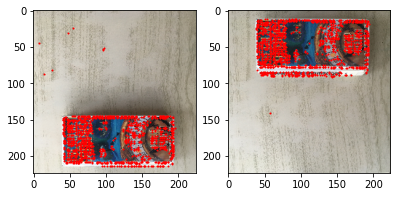

In [ ]:

img1_pts = np.float32([ kp.pt for kp in kp1 ])
img2_pts = np.float32([ kp.pt for kp in kp2])

plt.figure()
plt.subplot(1,2,1)
plt.imshow(img1)
plt.scatter(list(list(zip(*img1_pts))[0]), list(list(zip(*img1_pts))[1]), s=[1], c='r')
plt.subplot(1,2,2)
plt.imshow(img2)
plt.scatter(list(list(zip(*img2_pts))[0]), list(list(zip(*img2_pts))[1]), s=[1], c='r')
plt.show()